### Ансамблевые методы 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

**0. (0 баллов) ** Загрузите [датасет](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data), в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [4]:
path = "C:/Users/kiril/OneDrive/Рабочий стол/Дата Саенс/Проекты/ИАД/Введение в анализ данных/4/diabetes.csv"

In [5]:
data = pd.read_csv(path)

**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

In [4]:
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Думаю, что наличие нулей в некоторых колонках являвется фактом того, что это пропущенные значения. Во-первых, в данном датасете нет пропущенных значений, что немного удивляет. Во-вторых, нулевые значения являются пропусками, потому что не может быть такого, что у пациента есть такие медицинские характеристики, где стоит ноль... Однако признак Pregnancies может содержать ноль, так может быть нулевой срок беременности. Заменим нулевые значения на среднее значения по признаку в следующих столбцах: Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age. Возраст тоже не может быть нулевым, так как данные собирали у женщин. Глюкоза, давление в крови, толщина кожи, инсулин тоже не могут быть равны нулю. Последние два признака не понятно что (информации о них не нашел на kaggle), но предположим, что они тоже не могу быть равны нулю...

In [6]:
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [7]:
for column in columns:
    data.loc[data[column] == 0, column] = data.loc[data[column] != 0, column].mean()

**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых. Ваши графики должны быть примерно такими:

![Image](https://d.radikal.ru/d03/2005/f8/0ffb9443cbcf.png)

In [6]:
columns = data.columns.tolist()
columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

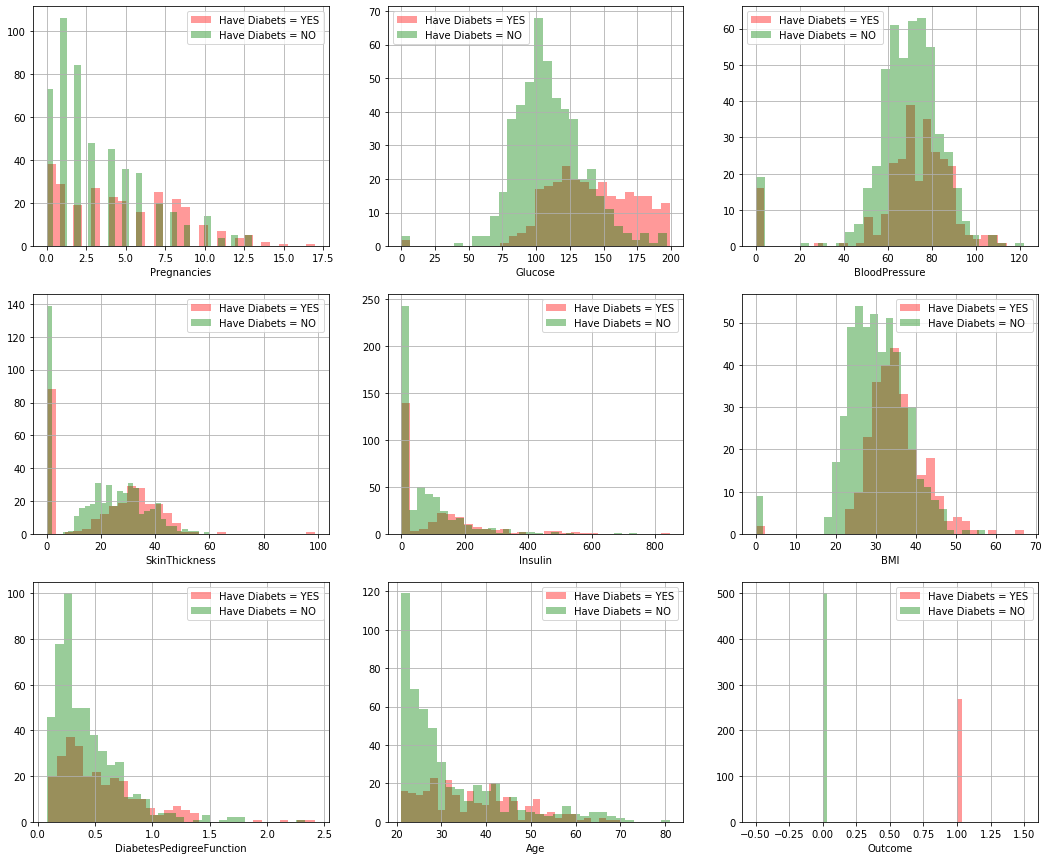

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
dict_axes = {0:ax[0, 0], 1:ax[0, 1], 2:ax[0, 2], 3:ax[1, 0], 4:ax[1, 1], 5:ax[1, 2], 6:ax[2, 0], 7:ax[2, 1], 8:ax[2, 2]}
for i in range(len(columns)):
    data_diab = data.loc[data['Outcome'] == 1]
    data_no_diab = data.loc[data['Outcome'] == 0]
    sns.distplot(data_diab[columns[i]], ax=dict_axes[i], label='Have Diabets = YES', color='red', bins=30, kde=False)
    sns.distplot(data_no_diab[columns[i]], ax=dict_axes[i], label='Have Diabets = NO', color='green', bins=30, kde=False)
    dict_axes[i].grid()
    dict_axes[i].legend()
plt.show()

**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите *BaggingClassifier* на деревьях (поставьте параметр *base_estimator = DecisionTreeClassifier()*) и *RandomForest*. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

*tip: создайте отдельную функцию для вывода метрик качества;*

In [8]:
def metrics(y_true, y_pred):
    print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
    print(f'Precision: {precision_score(y_true, y_pred)}')
    print(f'Recall: {recall_score(y_true, y_pred)}')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

#### BaggingClassifier

In [16]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=7)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=7)

In [17]:
y_pred = bagging.predict(X_test)
metrics(y_test, y_pred)

Accuracy: 0.7359307359307359
Precision: 0.6419753086419753
Recall: 0.6190476190476191


#### RandomForestClassifier

In [18]:
forest = RandomForestClassifier(n_estimators=10, random_state=7)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=7)

In [19]:
y_pred = forest.predict(X_test)
metrics(y_test, y_pred)

Accuracy: 0.7619047619047619
Precision: 0.6986301369863014
Recall: 0.6071428571428571


Разные результаты метрик можно объяснить тем, что модели отличаются тем, как обучаются. В случае модели Bagging мы каждую базовую модель решающего дерева обучаем на новой сгенерированной выборке с помощью бутстрапа. В целом тот же принцип и при обучении случайного леса, но в случайном лесе в каждой вершине каждого решающего дерева мы берем случайным образом определенное количество признаков, что уменьшает зависимость деревьев между друг другом. Но и в том, и в другом случае решение принимается голосованием по большинсту.

**4. (2 балл)** Для случайного леса проанализируйте значение ROC-AUC на этих же данных в зависимости от изменения параметров:
* *n_estimators* (можно перебрать около 10 значений из отрезка от 10 до 1500)
* *min_samples_leaf* (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости ROC-AUC от этих параметров. Какие выводы можете сделать?

In [18]:
from sklearn.metrics import roc_auc_score

In [19]:
leaves = list(range(1, 20, 2))

In [20]:
estimators = list(range(50, 1500, 150))

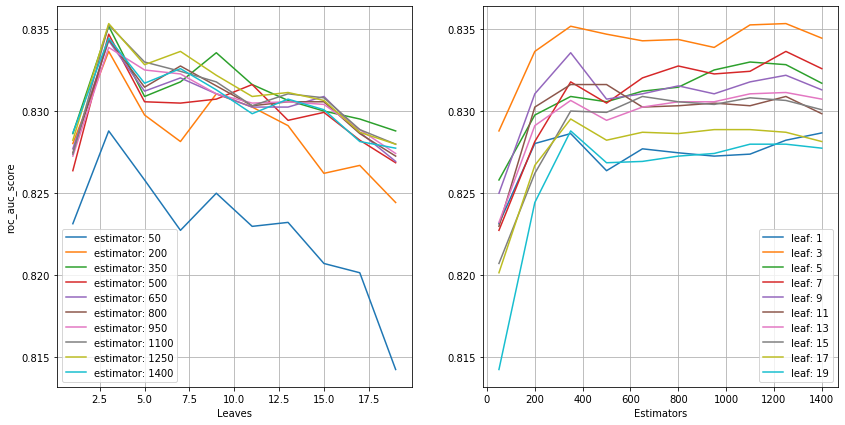

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

for estimator in estimators:
    roc_auc_scores_leaf = []
    for leaf in leaves:
        model_leaf = RandomForestClassifier(n_estimators=estimator, min_samples_leaf=leaf, random_state=7)
        model_leaf.fit(X_train, y_train)
        y_prob = model_leaf.predict_proba(X_test)
        roc_auc_scores_leaf.append(roc_auc_score(y_test, y_prob[:, 1]))
    sns.lineplot(x=leaves, y=roc_auc_scores_leaf, ax=ax[0], label=f'estimator: {estimator}')

for leaf in leaves:
    roc_auc_scores_estim = []
    for estimator in estimators:
        model_estim = RandomForestClassifier(n_estimators=estimator, min_samples_leaf=leaf, random_state=7)
        model_estim.fit(X_train, y_train)
        y_prob = model_estim.predict_proba(X_test)
        roc_auc_scores_estim.append(roc_auc_score(y_test, y_prob[:, 1]))
    sns.lineplot(x=estimators, y=roc_auc_scores_estim, ax=ax[1], label=f'leaf: {leaf}')
        
ax[1].set_xlabel('Estimators')
ax[0].set_xlabel('Leaves')
ax[0].set_ylabel('roc_auc_score')
ax[0].grid()
ax[1].grid()
plt.show()

Рассмотрим первый график, где фиксируем число n_estimators и перебираем всевозможные значения гиперпараметра min_samples_leaf при конкретном n_estimators. Заметим, что смещение моделей моделей относительно друг друга низкое, так как графики расположены примерно по одной и той же траектории и сконцентрированы в одном месте (отбивается от других только модель при n_estimators=50, так как слабо обучена). Можно сделать вывод, что гиперпараметр n_estimators влияет на качество модель незначительно, а min_samples_leaf стоит подбирать. По графику видно, что оптимальное число min_samples_leaf равно 3. Наш вывод подтверждает также и второй график, где смещение моделей уже видно значительно при изменении фиксированного гиперпараметра min_samples_leaf. Видим уровни качества модели при разном значении min_samples_leaf. Наибольшее качество модели при значении 3. А оптимальное число n_estimators равно примерно 350.

**5. (1 балл)**. Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим аттрибутом случайного леса в библиотеке sklearn, чтобы построить barplot.

In [22]:
features = X.columns.tolist()
importances = forest.feature_importances_
importances

array([0.07337978, 0.24087107, 0.07455575, 0.08238285, 0.0667275 ,
       0.16541474, 0.15043142, 0.14623688])

In [23]:
feat_imp = pd.DataFrame(importances, index=features, columns=['Importance'])
feat_imp

,Importance
Pregnancies,0.073380
Glucose,0.240871
BloodPressure,0.074556
SkinThickness,0.082383
Insulin,0.066727
BMI,0.165415
DiabetesPedigreeFunction,0.150431
Age,0.146237


In [24]:
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

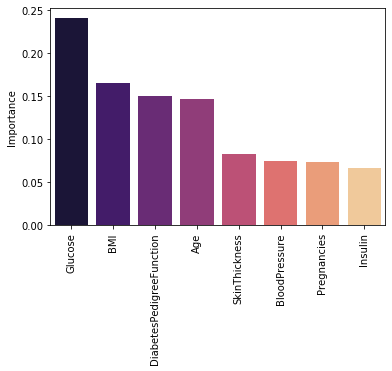

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=feat_imp, y='Importance', x=feat_imp.index.tolist(), palette='magma', ax=ax)
plt.xticks(rotation=90)
plt.show()

Наиболее важными признаками оказались: Glucose, BMI, DiabetesPedigreeFunction, Age.

**6. (2 балла)** Обучите HistGradientBoostingClassifier и GradientBoostingClassifier из sklearn. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

In [26]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

Разница этих моделей заключается в том, что модель HGBC разделяет выборку X на целочисленное количество бинов (число бинов задаем заранее в модели как гиперпараметр max_bins) по каждому признаку с помощью квантилей, в самом начале обучения сохраняя эти пороги. И уже при обучении в каждой вершине каждого дерева алгоритм выбирает порог для разбиения не через перебор всех значений признака, а с помощью перебора сохраненных в самом начале порогов. Это является преимуществом модели HGBC перед GBC, так как на достаточно больших выборках (где объектов больше 10000) обучение модели проходит значительно быстрее, чем простой перебор всех значений признака при разбиении в вершине в случае обычного GBC.

In [27]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)

#### HistGradientBoostingClassifier

In [28]:
hist_gb_grid = GridSearchCV(
    HistGradientBoostingClassifier(),
    param_grid={
        'max_iter': range(50, 1000, 50)
    },
    cv=cv,
    n_jobs=-1
)

In [29]:
%%time
hist_gb_grid.fit(X_train, y_train)

Wall time: 26.5 s


GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_iter': range(50, 1000, 50)})

In [30]:
hist_gb_grid.best_params_

{'max_iter': 50}

In [31]:
%%time
hist_gb = HistGradientBoostingClassifier(max_iter=50, random_state=7)
hist_gb.fit(X_train, y_train)

Wall time: 311 ms


HistGradientBoostingClassifier(max_iter=50, random_state=7)

In [32]:
y_pred = hist_gb.predict(X_test)
metrics(y_test, y_pred)

Accuracy: 0.7662337662337663
Precision: 0.6744186046511628
Recall: 0.6904761904761905


#### GradientBoostingClassifier

In [33]:
gb_grid = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid={
        'n_estimators': range(50, 1000, 50)
    },
    cv=cv,
    n_jobs=-1
)

In [34]:
%%time
gb_grid.fit(X_train, y_train)

Wall time: 11.7 s


GridSearchCV(cv=KFold(n_splits=5, random_state=7, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'n_estimators': range(50, 1000, 50)})

In [35]:
gb_grid.best_params_

{'n_estimators': 150}

In [36]:
%%time
gb = GradientBoostingClassifier(n_estimators=150, random_state=7)
gb.fit(X_train, y_train)

Wall time: 171 ms


GradientBoostingClassifier(n_estimators=150, random_state=7)

In [37]:
y_pred = gb.predict(X_test)
metrics(y_test, y_pred)

Accuracy: 0.7748917748917749
Precision: 0.6777777777777778
Recall: 0.7261904761904762


**7. (1.5 балла)** Вспомните, что представляет собой [стэкинг моделей](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier). Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классфикатор из уже вами изученных на курсе. Как final_estimator используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

In [38]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

*tip: не забудьте завести список базовых алгоритмов*
<code>
base_learners = [
                 ('name1', model1(),
                 ('name2', model2())             
                ]

</code>

In [39]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=350, min_samples_leaf=3, random_state=7)),
    ('lr', LogisticRegression(random_state=7))
]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=-1)

In [40]:
stack_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(min_samples_leaf=3,
                                                       n_estimators=350,
                                                       random_state=7)),
                               ('lr', LogisticRegression(random_state=7))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [41]:
y_pred = stack_clf.predict(X_test)

In [42]:
metrics(y_test, y_pred)

Accuracy: 0.7619047619047619
Precision: 0.704225352112676
Recall: 0.5952380952380952


Сложно сказать улучшилось ли качество, так как не понятно, по какой метрике конкретно оценивать. По метрике recall модель явно проиграл всем моделям выше. По метрике Precision модель лучше других, по метрике же Accuracy не уступает другим.